# Teaching A Computer To Play Blackjack

*Authors:*
- Kelsey Cribari - Kelsey.Cribari@gmail.com
- Brandt Reutimann - brandtreutimann@gmail.com
- Courtney Schulze - Courtney.Schulze@colostate.edu

*Date: December, 2017*

## Introduction
*The What. The Why. The How.*

It all started when a member of the iconic trio went to Las Vegas for a weekend over the semester. While she had never gambled before, everyone would soon find out that Courtney loved blackjack ... a lot. Although her wallet was empty, Courtney left Vegas rich in experience and Blackjack knowledge. Born out of that trip and lost money came an idea, an idea for a CS440 final project.

For those of you reading this report who might not know, in the game of blackjack, players are dealt two cards, and they are dealt cards until they reach or get as close as then can to a card value totaling twenty-one. If the player’s total goes over twenty-one, the player busts and they lose their money. If the player’s total is less than the dealer’s total, the player also loses their money. Really, the player tends to lose their money quite a lot. However, there is a generally universally accepted basic blackjack strategy. If players play with this proper strategy, then the dealer only has about a 0.05% advantage. In other words, “if you are playing for $100 per hand, you can expect to lose about 50 cents each hand.” A chart of this proper strategy is found below:

![alt text](https://www.blackjackclassroom.com/wp-content/uploads/2017/02/Blackjack-Basic-Strategy-Chart.png "Basic Blackjack Strategy")
(Photo courtesy of [Blackjack Classroom](https://www.blackjackclassroom.com/blackjack-basic-strategy-charts))

Because of this interesting nature of the basic blackjack strategy, we thought it would be a fascinating project to try training a computer to play blackjack through basic artifical intelligence principles, namely reinforcement learning. Would the computer naturally learn the strategy that all professional blackjack players accept as “proper”? That’s what we set to find out.

### Overview of Methods:
* Temporal Difference Reinforcement Learning: In the inital implementation of the game, we used reinforcements of 1 if you beat the dealer, 0 if you push (tie with the dealer), and -1 if you lose.

### Overview of Results:
** put results here **

## Method
*The steps we took. The resources we used. The work we shared.*

### Phase One:
The first phase was comprised of creating deck, player, and dealer representations for the game. Feel free to run the code below.

#### Deck:
*Main Author: Brandt Reutimann*

The deck is a relatively standard card deck, except suits are naturally ignored. All face cards are represented by 10's (since for blackjack, a king is the same as a queen which is the same as a ten). 

A new deck is shuffled by default. This feature can be turned off by passing ```deck = BlackJackDeck (shuffleCards = False)```.

Suits and faces can be activated with ```deck = BlackJackDeck (SuitsAndFaces = True)```.

In [1]:
from src.Deck import BlackJackDeck

In [2]:
print ("Example of drawing 10 random cards without suits or faces:")
deck = BlackJackDeck()
for i in range (0, 10):
    print (deck.drawCard())

Example of drawing 10 random cards without suits or faces:
10
A
3
10
10
10
9
8
2
6


In [3]:
print ("Example of drawing 10 random cards with suits and faces:")
deckSuits = BlackJackDeck(SuitsAndFaces = True)
for i in range (0, 10):
    print (deckSuits.drawCard())

Example of drawing 10 random cards with suits and faces:
('Q', 'S')
(5, 'C')
('Q', 'H')
(8, 'S')
(4, 'C')
('Q', 'D')
(8, 'H')
(2, 'S')
(5, 'D')
(6, 'S')


#### Player:
*Main Author: Courtney Schulze*

A player consists of a hand and a current card count (which is the current card total of the cards in their hand). A player has a list of valid moves they can make (either stand or hit). When a player hits, a card is drawn from the deck and added to the player's hand. If the card count after the new card is greater than 21, then the player busts. 

In [4]:
from src.Player import Player

In [5]:
# create both deck and player
deck = BlackJackDeck()
player = Player()

#put first two cards in player's hand
player.addCardToHand(deck.drawCard())
player.addCardToHand(deck.drawCard())

print("The player's current hand is: " + str(player.getHand()))
print("The cards in the player's hand total: " + str(player.getCardCount()))
print("Valid moves: " + str(player.validMoves()))

The player's current hand is: [3, 10]
The cards in the player's hand total: 13
Valid moves: ['stand', 'hit', 'double']


In [6]:
print("The player takes a card. Here are the results: " + str(player.hit(deck)))
print("The player busted based on the previous hit: " + str(player.bust))

The player takes a card. Here are the results: [3, 10, 10]
The player busted based on the previous hit: True


What happens if the player keeps hitting until they get to a total greater than 21?

In [7]:
if (player.getCardCount() < 21):
    while not player.bust:
        result = player.hit(deck)
        print("Player's hand: " + str(player.getHand()))
    print("Player busted! Card total was: " + str(player.getCardCount()))

#### Dealer:
*Main Author: Kelsey Cribari*

A dealer is pretty much a player, but they have a more specific ruleset they have to follow in terms of valid moves.

In [8]:
from src.Dealer import BlackJackDealer

In [9]:
# create both dealer and deck
deck = BlackJackDeck()
dealer = BlackJackDealer()

dealer.hand.append(deck.drawCard())
# deal second card to dealer
dealerFaceCard = deck.drawCard()
dealer.hand.append(dealerFaceCard)
# keep track of the card that is face up on the dealer so the player knows what to base their moves off of
dealer.faceUpCard = dealerFaceCard

print("Dealer's faceup card: " + str(dealer.faceUpCard))
print("Dealer's hand: " + str(dealer.hand))
print("The dealer has to: " + str(dealer.dealerValidMoves()))

Dealer's faceup card: 6
Dealer's hand: [9, 6]
The dealer has to: hit


### Phase Two:
This phase consisted of doing the game representation and writing the trainQ and testQ methods.

#### Game
*Main Authors: Kelsey Cribari and Brandt Reutimann*

** Kelsey is going to write things here **

In [10]:
from src.Game import BlackJackGame

#### Reinforcement Learning

*Main Authors: Kelsey Cribari and Brandt Reutimann*

We used a temporal difference strategy for training the player agent in our BlackJack game. Essentially the player is reinforced +1 for a win, -1 for a loss, and 0 for a push (draw). If the player doubles down and wins, it is reinforced +2, but conversely if it loses it is reinforced -2. All the reinforcement is contained in our trainQ function.

We then use a testQ function to simulate playing a number of games. The testQ function keeps track of wins and earnings to simulate how well the agent performs using it's knowledge.

In [11]:
game = BlackJackGame()
Q = game.trainQ(100000, .6, .8)
print ('calling testQ')
winRate, earnings = game.testQ(Q, 1000, verbose=True)
print ('Win rate was: {}, Earnings: ${}'.format(winRate, earnings))

calling testQ
Initial Hand: [7, 2], Bet: 5, Player: [7, 2, 10], Dealer: [5, 10, 10], Result: win
Win rate was: 45.6, Earnings: $75


#### Exploring Learning Rate & Epsilon Decay
*Main Authors: Courtney Schulze*

In order to make our learning algorithm effective, we wanted to find the right combination of learning rate and epsilon decay that would maximize winning. 

If the learning rate is too high the agent might become too confident if it got lucky on a move that is actually bad.
For example, let's say the agent hits on a 20 against a dealer 10 and luckily receives an Ace, thus winning the hand. If the learning rate is too high, the agent may have to much confidence in hitting in this scenario again. Or the opposite scenario is that AI becomes risk adverse as result of hitting and losing in a strategically correct scenario.

For epsilon, we want to insure that the agent explores as many random moves as possible. BlackJack has a lot of possible scenarios for the agent to encounter. There are combinations of sums and Aces all the way up to 21, in addition to variance in the dealer's upcard. In order to learn to be a BlackJack expert, the agent has to encounter all of these scenarios and explore different moves to determine which strategy is best. If epsilon is too low, the AI might not enough experimentation before relying on it's own experience (Q table).

In [12]:
def averageWinRate(learningRate, epsilonDecayFactor):
    sumWin = 0.0
    for i in range(10):
        game = BlackJackGame()
        Q = game.trainQ(100000, learningRate, epsilonDecayFactor)
        winRate, _ = game.testQ(Q, 1000)
        sumWin += winRate
    
    return sumWin / 10

print("Average win rate for learningRate = 0.6 and epsilonDecayFactor = 0.8: " + str(averageWinRate(0.6, 0.8)))

Average win rate for learningRate = 0.6 and epsilonDecayFactor = 0.8: 44.69


In most versions of the average win rate above, the win rate comes out to about 45%. This makes sense: when playing with proper strategy, the house should only have about a 0.05% advantage, bringing the player's win rate to 45%. According to [Wizard of Odds](https://wizardofodds.com/games/blackjack/appendix/4/), the probability of a net win in blackjack is 42.42%. If ties are ignored, that jumps to about 46.35%. However, we wondered if we could make that win rate better by playing around with the learning rate and epsilon decay factor for 100,000 iterations. Therefore, Courtney put on her investigation hat to see how high we could get that win rate.

In [13]:
def testDifferentValues():
    print("Testing learningRate = 0.5 and epsilonDecayFactor = 0.5")
    print("Average win rate for learningRate = 0.5 and epsilonDecayFactor = 0.5: " + str(averageWinRate(0.5, 0.5)))
    
    print("Testing learningRate = 0.99 and epsilonDecayFactor = 0.3")
    print("Average win rate for learningRate = 0.99 and epsilonDecayFactor = 0.3: " + str(averageWinRate(0.99, 0.3)))
    
    print("Testing learningRate = 0.99 and epsilonDecayFactor = 0.8")
    print("Average win rate for learningRate = 0.99 and epsilonDecayFactor = 0.8: " + str(averageWinRate(0.99, 0.8)))
    
    print("Testing learningRate = 0.3 and epsilonDecayFactor = 0.3")
    print("Average win rate for learningRate = 0.3 and epsilonDecayFactor = 0.3: " + str(averageWinRate(0.3, 0.3)))
    
    print("Testing learningRate = 0.3 and epsilonDecayFactor = 0.99")
    print("Average win rate for learningRate = 0.3 and epsilonDecayFactor = 0.99: " + str(averageWinRate(0.3, 0.99)))

print("Please be prepared to wait a while.")
testDifferentValues()

Please be prepared to wait a while.
Testing learningRate = 0.5 and epsilonDecayFactor = 0.5
Average win rate for learningRate = 0.5 and epsilonDecayFactor = 0.5: 45.08
Testing learningRate = 0.99 and epsilonDecayFactor = 0.3
Average win rate for learningRate = 0.99 and epsilonDecayFactor = 0.3: 44.13
Testing learningRate = 0.99 and epsilonDecayFactor = 0.8
Average win rate for learningRate = 0.99 and epsilonDecayFactor = 0.8: 44.190000000000005
Testing learningRate = 0.3 and epsilonDecayFactor = 0.3
Average win rate for learningRate = 0.3 and epsilonDecayFactor = 0.3: 45.32000000000001
Testing learningRate = 0.3 and epsilonDecayFactor = 0.99
Average win rate for learningRate = 0.3 and epsilonDecayFactor = 0.99: 45.220000000000006


Taking a look at these results, the best thing to do seems to be use a bit lower of a learning rate, and don't make the epsilonDecayFactor too large or small.

#### Betting Strategy

In order to make the game more interesting we wanted to incorporate some betting strategy. We figured that implementing a learning strategy for betting would be trivial. This is because in the long run the goal is to maximize earnings. Therefore, the agent should eventually determine that it is losing money the longer it plays and hence always gamble the minimum. This is an assumption that will need to be tested in future experiments.

For our project we decided to use a different approach to bettting. We call this strategy hotstreak betting. Essentially, the more wins the agent gets consecutively the higher it will bet with each consecutive win. We wanted to model it after the fallacy of many gamblers: "I'm on a lucky streak right now, I should bet more". We thought this was an interesting notion to test in our agent, especially for observing how this betting strategy effects earnings.

We implemented this strategy by keeping a count of consecutive wins. If the agent loses this count is reset to 0 and if the agent draws we decrement the count by 1 (maybe shaking its feeling of luck a little). Then in a determineBet function we use a soft exponential curve to determine how much the agent will bet. The hardness (exponetial slope) of this curve can be modified by increasing the streak factor. You can also disable this hotstreak betting strategy by setting the hotstreak flag to false. How much the player bets is based on a minimum bet amount, if there is no hotstreak strategy then the agent always bets the minimum unless doubling down.

In [14]:
# Implement hotstreak betting
def determineBet (self, consecutiveWins, minBet = 5, streakFactor = 1.2, hotstreak = True):
    if hotstreak is False:
        return minBet
    return round(minBet ** streakFactor) if consecutiveWins > 0 else minBet

## Results
*The results we got.*

#### Comparing our agent to a random player

As we have observed earlier, our agent's win rate will hover around 45 - 46%. Let's see how this compares to a random player.

We are going to modify averageWinRate to take a few extra arguments. Mostly, we want to specify iterations to see if our agent improves with more training. Also, we want to add an argument to calculate average win rate for a random player.

In [15]:
import matplotlib.pyplot as plt
import time

In [16]:
# Modify average win rate to include iteration parameter
def averageWinRate(learningRate, epsilonDecayFactor, iterations = 100000, random = False):
    sumWin = 0.0
    for i in range(10):
        game = BlackJackGame()
        Q = {}
        if random:
            winRate, _ = game.testQ(Q, 5000, esp = 1)
        else:
            Q = game.trainQ(iterations, learningRate, epsilonDecayFactor)
            winRate, _ = game.testQ(Q, 5000) # Also up the number of games played to 5000
        sumWin += winRate
    
    return sumWin / 10

In [17]:
winRates = []
iters = []
for i in range (1, 6):
    # Test iterations in powers of 10
    iterations = 10 ** i
    iters.append(iterations)
    st = time.time()
    avgWin = averageWinRate(.3, .99, iterations = iterations)
    et = time.time()
    winRates.append(avgWin)
    print ('Training complete for {} iterations. Time {:.2f} seconds'.format(iterations, et - st))

Training complete for 10 iterations. Time 2.58 seconds
Training complete for 100 iterations. Time 3.01 seconds
Training complete for 1000 iterations. Time 3.72 seconds
Training complete for 10000 iterations. Time 10.26 seconds
Training complete for 100000 iterations. Time 79.53 seconds


In [18]:
randRates = []
rIters = []
for i in range (1,6):
    iterations = 10 ** i
    rIters.append(iterations)
    avgWin = averageWinRate(.3, .99, random = True)
    randRates.append(avgWin)
randRates

[31.768,
 31.857999999999997,
 32.025999999999996,
 32.10199999999999,
 31.561999999999994]

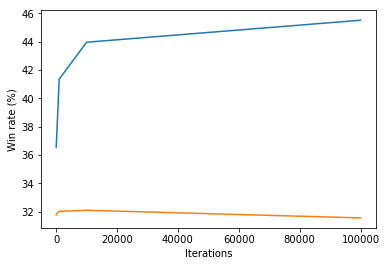

In [19]:
plt.plot(iters, winRates)
plt.plot(rIters, randRates)
plt.ylabel('Win rate (%)')
plt.xlabel('Iterations')
# plt.figure(figsize=(14,4), dpi=160)
plt.show()

#### Comparing our agent to "proper" blackjack strategy

Having a win rate of about 45% is fine and dandy, and having a higher win rate than a random player is great as well. However, our initial research question wanted to take a look at if by using reinforcement learning, a computer would learn "proper" blackjack strategy. The code below creates a Q table and constructs a basic chart from that Q table.

In [20]:
game = BlackJackGame()
Q = game.trainQ(100000, .6, .8)

In [21]:
def bestMoveGivenState(Q, playerVal, dealerUp, verbose = False):
    reinforcement = float('-inf')
    move = None
    if Q.get((playerVal, dealerUp, 'hit'), float("-inf")) > reinforcement:
        reinforcement = Q[(playerVal, dealerUp, 'hit')]
        move = 'H'
    if Q.get((playerVal, dealerUp, 'stand'), float("-inf")) > reinforcement:
        reinforcement = Q[(playerVal, dealerUp, 'stand')]
        move = 'S'
    if Q.get((playerVal, dealerUp, 'double'), float("-inf")) > reinforcement:
        reinforcement = Q[(playerVal, dealerUp, 'double')]
        move = 'D'
    
    if (verbose):
        print("Reinforcement for HIT: " + str(Q[(playerVal, dealerUp, 'hit')]))
        print("Reinforcement for STAND: " + str(Q[(playerVal, dealerUp, 'stand')]))
        print("Reinforcement for DOUBLE: " + str(Q[(playerVal, dealerUp, 'double')]))
        
    return move

In [22]:
bestMoveGivenState(Q, 19, 'A', True)

Reinforcement for HIT: -0.999682638203544
Reinforcement for STAND: -0.19999999999999996
Reinforcement for DOUBLE: -1.5983616


'S'

In [23]:
import copy
def percentageMatching(Q):
    matching = 0
    dealerUp = [2, 3, 4, 5, 6, 7, 8, 9, 10, 'A']
    
    #here are the rows in the actual blackjack chart
    twentyone = ['S']*10
    sixteen = ['S']*5 + ['H']*5
    twelve = ['H']*2 + ['S']*3 + ['H']*5
    eleven = ['D']*9 + ['H']
    ten = ['D']*8 + ['H']*2
    nine = ['H'] + ['D']*4 + ['H']*5
    eight = ['H']*10
    
    #calculate 17+
    counter = 0
    for up in dealerUp:
        if bestMoveGivenState(Q, 21, up) is twentyone[counter]:
            matching += 1
        if bestMoveGivenState(Q, 20, up) is twentyone[counter]:
            matching += 1
        if bestMoveGivenState(Q, 19, up) is twentyone[counter]:
            matching += 1
        if bestMoveGivenState(Q, 18, up) is twentyone[counter]:
            matching += 1
        if bestMoveGivenState(Q, 17, up) is twentyone[counter]:
            matching += 1
        if bestMoveGivenState(Q, 16, up) is sixteen[counter]:
            matching += 1
        if bestMoveGivenState(Q, 15, up) is sixteen[counter]:
            matching += 1
        if bestMoveGivenState(Q, 14, up) is sixteen[counter]:
            matching += 1
        if bestMoveGivenState(Q, 13, up) is sixteen[counter]:
            matching += 1
        if bestMoveGivenState(Q, 12, up) is twelve[counter]:
            matching += 1
        if bestMoveGivenState(Q, 11, up) is eleven[counter]:
            matching += 1
        if bestMoveGivenState(Q, 10, up) is ten[counter]:
            matching += 1
        if bestMoveGivenState(Q, 9, up) is nine[counter]:
            matching += 1
        if bestMoveGivenState(Q, 8, up) is eight[counter]:
            matching += 1
        if bestMoveGivenState(Q, 7, up) is eight[counter]:
            matching += 1
        if bestMoveGivenState(Q, 6, up) is eight[counter]:
            matching += 1
        if bestMoveGivenState(Q, 5, up) is eight[counter]:
            matching += 1
        counter += 1
 
    return (matching / 170) * 100

game = BlackJackGame()
Q = game.trainQ(100000, .6, .8)
percentageMatching(Q)

77.64705882352942

The amount our Q table matches the top-third of the proper blackjack chart is usually around 77% ... not bad! This method doesn't account for if there's an ace in the player's hand. The agent doesn't seem to like doubling down a lot, and I don't blame it! Better to play it safe.

Let's take a look at how much the Q table matches the chart if we train it for a different number of iterations.

In [24]:
iterations = 1
iters = []
perCorrect = []
for i in range(6):
    iters.append(iterations)
    game = BlackJackGame()
    Q = game.trainQ(iterations, 0.6, 0.8)
    perCorrect.append(percentageMatching(Q))
    print ('Training complete for {} iterations.'.format(iterations))
    iterations = iterations * 10

Training complete for 1 iterations.
Training complete for 10 iterations.
Training complete for 100 iterations.
Training complete for 1000 iterations.
Training complete for 10000 iterations.
Training complete for 100000 iterations.


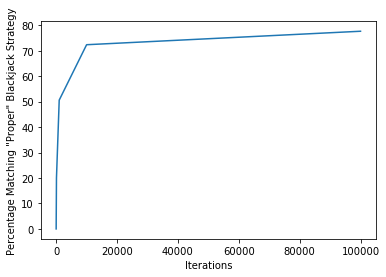

In [25]:
plt.plot(iters, perCorrect)
plt.ylabel('Percentage Matching "Proper" Blackjack Strategy')
plt.xlabel('Iterations')
plt.show()

As you can see by the plot above, our Q table quickly tops out at around 77% matching.

** Betting Strategy and Earnings **

## Conclusions
*The things we learned.*